# Setup

In [222]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import datasets, layers, models
from keras.utils import np_utils
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



warnings.filterwarnings("ignore")


# Prepare the data

In [223]:

# At first we mount the dataset from local file
inputdf = pd.read_csv('Crime.csv')
# sneak peak in the data
inputdf.head(2)

,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,12/21/2018 09:13:13 PM,120,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,...,NaN,GEORGIA,NaN,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,09/13/2020 12:26:58 AM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,COLTRANE,NaN,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

In [224]:
# dropping the unnecessary columns
#inputdf = data
unnecessary_columns = ['Incident ID', 'Offence Code', 'CR Number', 'NIBRS Code', 'State', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Suffix', 'Police District Number', 'Location'  ]
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Dispatch Date / Time,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,Block Address,City,Zip Code,Agency,Place,Street Name,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude
0,12/21/2018 09:13:13 PM,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,11100 BLK GEORGIA AVE,SILVER SPRING,20902.0,MCPD,Street - Bus Stop,GEORGIA,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499
1,09/13/2020 12:26:58 AM,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,25600 BLK COLTRANE DR,DAMASCUS,20872.0,MCPD,Parking Lot - Residential,COLTRANE,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115


# Later, Columns related with the effect of crime are removed.

In [225]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,Zip Code,Place,Street Name,Start_Date_Time,Latitude,Longitude
0,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,12/21/2018 09:13:00 PM,39.03627,-77.0499
1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,08/08/2020 05:10:00 PM,39.27784,-77.2115


Some columns are confusing to be added now. Such as -

* Crime Name3
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Drop rows from the dataframe based on certain condition applied on a column


In [226]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
# inputdf['Latitude'].hist()
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
# inputdf['Longitude'].hist()



# inputdf['Crime Name2'].value_counts()
# # Filter all rows for that has occurances less than 5
# inputdf = inputdf[inputdf.columns[inputdf['Crime Name2'].value_counts() > 5]]

# Creating The Location Based Crime Data Frame

In [233]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Zip Code', 'Place', 'Street Name', 'Latitude', 'Longitude']]
dates = pd.to_datetime(inputdf['Start_Date_Time'])
  
# extract Hours from Timestamp 
# rs = dates.dt.hour
# print(rs)
loc_crime_df['dateHour'] = dates.dt.hour
loc_crime_df['day'] = dates.dt.day
loc_crime_df['month'] = dates.dt.month
loc_crime_df.head()
# print(loc_crime_df.shape)
# loc_crime_df.dtypes


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,21,12
1,Crime Against Society,All Other Offenses,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,17,8,8
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,3,1
3,Other,All Other Offenses,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,2,3,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,16,7


In [234]:
# Removing Rows on Count condition
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)
threshold = 100
loc_crime_df = loc_crime_df.loc[loc_crime_df['Crime Name2'].isin(counts.index[counts >= threshold ])]

In [235]:
# Removing Rows on Count condition 
# Pruning garbage data
# loc_crime_df = loc_crime_df[~loc_crime_df['Crime Name2'] == "All Other Offenses"]
indexAge = loc_crime_df[ loc_crime_df['Crime Name2'] == "All Other Offenses" ].index
loc_crime_df.drop(indexAge , inplace=True)
loc_crime_df.head()
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)


# Taking only Top n classes in a column


In [236]:
# Change target column name here
target_column = 'Crime Name2'
top_n = 10
top_classes_dict = {}
top_classes_dict = loc_crime_df[target_column].value_counts().nlargest(top_n).to_dict()
top_classes_series = loc_crime_df[target_column].value_counts().nlargest(top_n)
print(top_classes_series)
print('Dictionary is + '+str(top_classes_dict))
str_array = []
temp_df = pd.DataFrame()
for x in top_classes_dict.keys():
    str_array.append(x)
    rows = loc_crime_df[loc_crime_df[target_column] == str (x) ]
    # print(rows)
    temp_df = temp_df.append(rows)
# print(str_array)
# temp_df

Theft From Motor Vehicle                    26252
Drug/Narcotic Violations                    22573
Simple Assault                              21064
Destruction/Damage/Vandalism of Property    18967
Shoplifting                                 16416
All other Larceny                           13972
Driving Under the Influence                 13723
Theft from Building                         11335
Burglary/Breaking and Entering               8784
Identity Theft                               8633
Name: Crime Name2, dtype: int64
Dictionary is + {'Theft From Motor Vehicle': 26252, 'Drug/Narcotic Violations': 22573, 'Simple Assault': 21064, 'Destruction/Damage/Vandalism of Property': 18967, 'Shoplifting': 16416, 'All other Larceny': 13972, 'Driving Under the Influence': 13723, 'Theft from Building': 11335, 'Burglary/Breaking and Entering': 8784, 'Identity Theft': 8633}


In [237]:
loc_crime_df = temp_df
print(loc_crime_df[target_column].value_counts())

Theft From Motor Vehicle                    26252
Drug/Narcotic Violations                    22573
Simple Assault                              21064
Destruction/Damage/Vandalism of Property    18967
Shoplifting                                 16416
All other Larceny                           13972
Driving Under the Influence                 13723
Theft from Building                         11335
Burglary/Breaking and Entering               8784
Identity Theft                               8633
Name: Crime Name2, dtype: int64


# Handling null values in Zip code

In [238]:
# Replacing null values with mode value in Zip code
print(loc_crime_df.shape)
missing_value_column = 'Zip Code'
loc_crime_df[missing_value_column].fillna(loc_crime_df[missing_value_column].mode()[0], inplace=True)
print(loc_crime_df.shape)

(161719, 12)
(161719, 12)


In [239]:
# # Dropping null values in Zip code
# print(loc_crime_df.shape)
# # print(loc_crime_df['Zip Code'].value_counts())
# # loc_crime_df['dateHour'].value_counts()
# loc_crime_df = loc_crime_df.dropna(axis=0, subset=['Zip Code'])
# print(loc_crime_df.shape)

(161719, 12)
(161719, 12)


In [240]:
loc_crime_df.head()

,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
20,Crime Against Property,Theft From Motor Vehicle,SILVER SPRING,SILVER SPRING,20904.0,Parking Lot - Commercial,BRIGGS CHANEY,39.08299,-76.9481,11,7,11
31,Crime Against Property,Theft From Motor Vehicle,ROCKVILLE,ROCKVILLE,20852.0,Parking Lot - Commercial,JEFFERSON,39.05840,-77.1263,20,27,1
61,Crime Against Property,Theft From Motor Vehicle,SILVER SPRING,SILVER SPRING,20904.0,Parking Lot - Commercial,PROSPERITY,39.06081,-76.9634,10,17,9
98,Crime Against Property,Theft From Motor Vehicle,BETHESDA,CHEVY CHASE,20815.0,Residence - Driveway,GLENMOOR,39.00547,-77.0720,20,28,12
116,Crime Against Property,Theft From Motor Vehicle,GERMANTOWN,GERMANTOWN,20874.0,Parking Lot - Residential,SWISS,39.15549,-77.2763,18,26,12


# Transform the data by label encoding

In [241]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform( loc_crime_df[target_column])
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
print(dummy_y)


[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [242]:
print(dummy_y.shape)

(161719, 10)


In [243]:
encoded_dict ={}
temp_df_2 = pd.DataFrame()

def label_encoder(y):
    le = LabelEncoder()
    if str(y) == target_column:
        print(loc_crime_df[y])
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
    if str(y) == target_column:
        print(loc_crime_df[y])
    if str(y) == target_column:
        temp_df_2[y] = le.inverse_transform(loc_crime_df[y])
        # encoded_dict = {loc_crime_df[y], temp_df_2[y]} 
    #print(temp_df[y])

#loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

# label_list = ['Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']

label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']

#label_list = ['Crime Name1']

for l in label_list:
    label_encoder(l)

# print(encoded_dict)
 
#Display transformed data
loc_crime_df.head()
print(loc_crime_df.shape)

20        Theft From Motor Vehicle
31        Theft From Motor Vehicle
61        Theft From Motor Vehicle
98        Theft From Motor Vehicle
116       Theft From Motor Vehicle
                    ...           
312116              Identity Theft
312129              Identity Theft
312201              Identity Theft
312240              Identity Theft
312248              Identity Theft
Name: Crime Name2, Length: 161719, dtype: object
20        8
31        8
61        8
98        8
116       8
         ..
312116    5
312129    5
312201    5
312240    5
312248    5
Name: Crime Name2, Length: 161719, dtype: int32
(161719, 12)


# Separating feature set and Target Class

In [244]:
# Going for specigic prediction without geolocation
# X = loc_crime_df.drop([target_column],axis=1)
# y = loc_crime_df[target_column]

# Going for specific prediction without geolocation
X = loc_crime_df.drop([target_column, 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column]


# Going for generic prediction
# X = loc_crime_df.drop([target_column,'Crime Name2', 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[[target_column, 'Latitude', 'Longitude']]

print(X)
X.shape

        Crime Name1  Police District Name  City  Zip Code  Place  Street Name  \
20                1                     6    34   20904.0     45          835   
31                1                     5    32   20852.0     45         3389   
61                1                     6    34   20904.0     45         5132   
98                1                     0    11   20815.0     61         2643   
116               1                     2    19   20874.0     51         6202   
...             ...                   ...   ...       ...    ...          ...   
312116            1                     5    32   20852.0     37         5275   
312129            1                     2     6   20841.0     37         3546   
312201            1                     2    19   20874.0     37           79   
312240            1                     5    17   20878.0     37         5844   
312248            1                     2    12   20871.0     15         1492   

        dateHour  day  mont

(161719, 9)

In [245]:
# Dropping a Pandas Index Column Using reset_index so that it doesn't have conflict with the second dataframe
df1 =loc_crime_df[['Latitude', 'Longitude']]
df1 = df1.reset_index(drop=True)
print(df1.shape)
df1.head()

(161719, 2)


,Latitude,Longitude
0,39.08299,-76.9481
1,39.05840,-77.1263
2,39.06081,-76.9634
3,39.00547,-77.0720
4,39.15549,-77.2763


In [246]:
df2=pd.DataFrame(dummy_y, columns = [x for x in str_array])
print(df2.shape)

df2.head()

(161719, 10)


,Theft From Motor Vehicle,Drug/Narcotic Violations,Simple Assault,Destruction/Damage/Vandalism of Property,Shoplifting,All other Larceny,Driving Under the Influence,Theft from Building,Burglary/Breaking and Entering,Identity Theft
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [247]:
# concatenate a mix of Series and DataFrame objects
y = pd.concat([df1, df2], axis = 1)
y=df2
y.shape
print(y)

        Theft From Motor Vehicle  Drug/Narcotic Violations  Simple Assault  \
0                            0.0                       0.0             0.0   
1                            0.0                       0.0             0.0   
2                            0.0                       0.0             0.0   
3                            0.0                       0.0             0.0   
4                            0.0                       0.0             0.0   
...                          ...                       ...             ...   
161714                       0.0                       0.0             0.0   
161715                       0.0                       0.0             0.0   
161716                       0.0                       0.0             0.0   
161717                       0.0                       0.0             0.0   
161718                       0.0                       0.0             0.0   

        Destruction/Damage/Vandalism of Property  Shoplifting  

In [248]:
# y = pd.concat([loc_crime_df[['Latitude', 'Longitude']], pd.DataFrame(dummy_y, columns = ['Y1', 'Y2'])], axis = 1, ignore_index= True)

# Split the data into training and testing set


In [249]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle = True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (129375, 9)
X_test shape: (32344, 9)
y_train shape: (129375, 10)
y_test shape: (32344, 10)


In [250]:
# Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Prediction with geolocation
sc_label = MinMaxScaler()
y_train = sc_label.fit_transform(y_train)
y_test = sc_label.transform(y_test)

# #Predicting only the last class
# y_train = y_train.iloc[:,-1:]
# y_test = y_test.iloc[:,-1:]

# # Predicting all top_n class
# y_train = y_train.iloc[:,-top_n:]
# y_test = y_test.iloc[:,-top_n:]

In [251]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [252]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [253]:
# plt.hist(y_train)

# Build and Train the model


In [254]:
print('Output class is: '+str(top_n))
# Md Hasan Shahriar
# Tue, Dec 6, 6:51 PM 


feature_number = 9
# with geolocation
output_dim = top_n+2
output_dim = top_n

model = keras.Sequential(
    [
        keras.Input(shape=feature_number),
        layers.Dense(100, activation="relu"),
        layers.Dense(250, activation="relu"),
        layers.Dense(500, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(output_dim, activation="softmax"),
        # layers.Dense(output_dim, activation="sigmoid"), # for binary classification
        # layers.Dense(output_dim, activation="softmax"),
    ]
)

model.summary()


batch_size = 128
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Output class is: 10
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 100)               1000      
                                                                 
 dense_61 (Dense)            (None, 250)               25250     
                                                                 
 dense_62 (Dense)            (None, 500)               125500    
                                                                 
 dense_63 (Dense)            (None, 100)               50100     
                                                                 
 dense_64 (Dense)            (None, 50)                5050      
                                                                 
 dense_65 (Dense)            (None, 10)                510       
                                                                 
Total params: 207,410
Trainable p

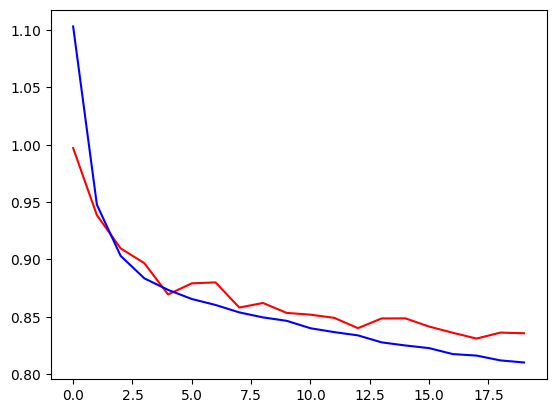

In [255]:
plt.plot(history.history['val_loss'], color = "red")
plt.plot(history.history['loss'], color = "blue")

In [256]:
np.round(model.predict(X_test[0:10]),2)

1/1 [==============================] - 0s 41ms/step


array([[0.  , 0.  , 0.  , 0.69, 0.31, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.15, 0.35, 0.1 , 0.  , 0.  , 0.25, 0.  , 0.  , 0.01, 0.14],
       [0.08, 0.  , 0.03, 0.  , 0.  , 0.  , 0.69, 0.  , 0.01, 0.19],
       [0.17, 0.01, 0.04, 0.  , 0.  , 0.72, 0.  , 0.  , 0.02, 0.04],
       [0.  , 0.  , 0.  , 0.19, 0.81, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.07, 0.25, 0.12, 0.  , 0.  , 0.28, 0.22, 0.  , 0.01, 0.06],
       [0.14, 0.46, 0.17, 0.  , 0.  , 0.09, 0.  , 0.  , 0.05, 0.1 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.78, 0.21, 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [257]:
np.round(y_test[0:10],2)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Evaluate the trained model


In [258]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8299278616905212
Test accuracy: 0.6620084047317505
